In [31]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [32]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
max_iter = 2000
cv = 3

In [33]:
participants = pd.read_csv(participants_file, index_col=0)


In [34]:
participants.head()

,isSynesthete,NOM,DDN,IRM name,Date IRM,Âge,Sexe,Latéralité,Remarques,Code BV,Unnamed: 9,2=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,SARR,10/8/1996,Sujet01,28/2/2023,26.569863,2,0,NaN,3,NaN,NaN,NaN
mv_SYNESTHEX_S_Session1_S2_T1w,1,LEFR,14/12/1950,Sujet02,9/3/2023,72.282192,2,0,NaN,S,NaN,NaN,NaN
mv_SYNESTHEX_M_Session1_S2_T1w,1,FERN,NaN,Sujet03,NaN,23.680000,1,0,NaN,M,NaN,NaN,NaN
mv_SYNESTHEX_K_Session1_S2_T1w,1,DERO,27/6/1997,Sujet04,21/10/2023,26.334247,1,0,NaN,K,NaN,NaN,NaN
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,DECH,NaN,Sujet05,NaN,21.110000,2,1,NaN,Sujet20,NaN,NaN,NaN


In [35]:
participants = participants[["isSynesthete", "Sexe", "Latéralité"]]

In [36]:
participants[:] = participants.sample(frac=1).values

In [37]:
participants

,isSynesthete,Sexe,Latéralité
participant_id,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,2,0
mv_SYNESTHEX_S_Session1_S2_T1w,0,1,0
mv_SYNESTHEX_M_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_K_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,0,1,0
mv_SYNESTHEX_Y_Session1_S2_T1w,0,2,0
mv_SYNESTHEX_Sujet25_Session1_S2_T1w,0,2,0
mv_SYNESTHEX_G_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_D_Session1_S2_T1w,1,2,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'Sexe'}>],
       [<Axes: title={'center': 'Latéralité'}>, <Axes: >]], dtype=object)

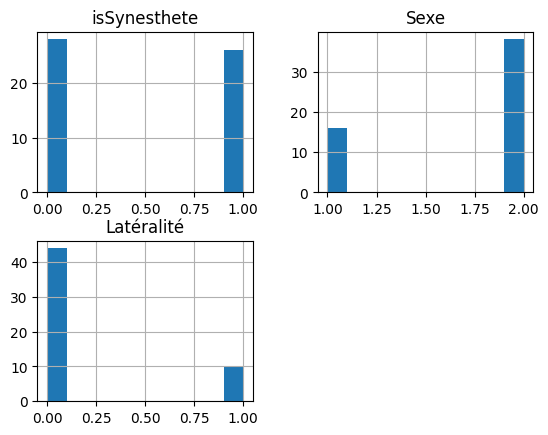

In [38]:
participants.hist()

In [39]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [40]:
model_paths = get_model_paths(path_champollion)

In [41]:
models_df = pd.DataFrame({"path":model_paths})

In [42]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [43]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    ukb_emb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]

    # Makes PCA on UkBioBank
    # print(ukb_emb.shape)
    pca = PCA(n_components=3)
    pca.fit(ukb_emb)

    # Transforms in synesthete dataset
    df2 = pd.DataFrame(pca.transform(X))
    df2.index = X.index

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    p_value = results.f_pvalue
    f_value = results.fvalue
    predictions = results.predict(df2)

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, predictions, Y)

In [44]:
participants.dtypes

isSynesthete    int64
Sexe            int64
Latéralité      int64
dtype: object

In [45]:
result = pd.DataFrame({})
for random_state in range(5):

    # Computes AUC
    for model_path in model_paths:
        ret = compute(model_path, random_state)
        f = ret[1].to_frame().T
        f.insert(0, "region", [ret[0]])
        result = pd.concat([result, f]).reset_index(drop=True)
        Y = ret[2]

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
0.5327574167473008
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
0.65796359075909
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.6636437120751488
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
2.2794306941910305
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
1.1571578606894721
Treating S.T.s.-S.GSM._left: STs-SGSM_left/13-57-40_59 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STs-SGSM_left/13-57-

In [46]:
result

,region,mv_SYNESTHEX_3-Session1_S2_T1w,mv_SYNESTHEX_S_Session1_S2_T1w,mv_SYNESTHEX_M_Session1_S2_T1w,mv_SYNESTHEX_K_Session1_S2_T1w,mv_SYNESTHEX_Sujet20_Session1_S2_T1w,mv_SYNESTHEX_Y_Session1_S2_T1w,mv_SYNESTHEX_Sujet25_Session1_S2_T1w,mv_SYNESTHEX_G_Session1_S2_T1w,mv_SYNESTHEX_D_Session1_S2_T1w,...,mv_SYNESTHEX_8-Session1_S2_T1w,mv_SYNESTHEX_L_Session1_S2_T1w,mv_SYNESTHEX_E_Session1_S2_T1w,mv_SYNESTHEX_Sujet19_Session1_S3_T1w,mv_SYNESTHEX_Sujet23_Session1_S3_T1w,mv_SYNESTHEX_Sujet24_Session1_S2_T1w,mv_SYNESTHEX_Sujet28_Session1_S2_T1w,mv_SYNESTHEX_Sujet21_Session1_S2_T1w,mv_SYNESTHEX_Sujet10_Session2_S14_T1w,mv_SYNESTHEX_Sujet15_Session2_S13_T1w
0,S.C.-sylv._left,0.370408,0.492426,0.656884,0.390727,0.475220,0.566850,0.446000,0.433615,0.357023,...,0.480131,0.512179,0.501700,0.407283,0.414131,0.720237,0.388990,0.430760,0.401466,0.518316
1,S.C.-sylv._left,0.418745,0.466490,0.668003,0.386964,0.499225,0.443520,0.424477,0.466858,0.338358,...,0.495595,0.514165,0.547692,0.412101,0.434338,0.765744,0.414752,0.540130,0.436526,0.546681
2,S.F.inter.-S.F.sup._left,0.534690,0.396727,0.582945,0.354177,0.342849,0.351222,0.516372,0.395745,0.436871,...,0.512557,0.620915,0.661709,0.385887,0.453759,0.478362,0.471796,0.695645,0.470709,0.477924
3,S.T.i.-S.T.s.-S.T.pol._right,0.495602,0.668658,0.629754,0.702690,0.170935,0.521274,0.554007,0.481500,0.405013,...,0.189921,0.415055,0.606366,0.251257,0.466078,0.207040,0.520262,0.334757,0.295237,0.638959
4,F.Coll.-S.Rh._right,0.384963,0.373336,0.712952,0.363116,0.282281,0.280042,0.577231,0.360400,0.538820,...,0.491244,0.504241,0.635805,0.425536,0.471129,0.461060,0.503734,0.458891,0.531739,0.399651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,S.C.-S.Po.C._left,0.332525,0.511983,0.720722,0.413747,0.445419,0.551795,0.501074,0.538385,0.369102,...,0.646681,0.408978,0.661850,0.525465,0.452659,0.721972,0.344031,0.408704,0.450615,0.488472
486,S.C.-S.Po.C._left,0.381185,0.503160,0.619412,0.466196,0.534792,0.573821,0.541610,0.478058,0.503577,...,0.612311,0.364048,0.637720,0.523039,0.547371,0.553521,0.464686,0.404795,0.471844,0.396791
487,S.C.-S.Po.C._left,0.301652,0.546906,0.595366,0.473309,0.416693,0.603894,0.581136,0.499506,0.526700,...,0.630820,0.383048,0.606058,0.469924,0.365858,0.526853,0.439121,0.333883,0.450403,0.357714
488,S.C.-S.Po.C._left,0.344666,0.421451,0.753378,0.411778,0.561999,0.547736,0.445554,0.343243,0.463247,...,0.578390,0.401637,0.688991,0.360368,0.515167,0.727163,0.391347,0.543010,0.414080,0.602315


In [47]:
ensemble = result.groupby("region").mean()

In [48]:
res_ensemble = []
for row in ensemble.iterrows():
    df2 = row[1].copy().to_frame()
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y, df2)
    results = model.fit()
    res_ensemble.append((row[0], results.fvalue, results.f_pvalue))

In [49]:
res_ensemble

[('CINGULATE_left', 3.225679122003025, 0.07830240265013334),
 ('CINGULATE_right', 2.2139568648766663, 0.14280701635337276),
 ('F.C.L.p.-S.GSM._left', 1.277984030201235, 0.26346155216345224),
 ('F.C.L.p.-S.GSM._right', 16.919278174454544, 0.00013933349645579705),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._left',
  1.1329698194659572,
  0.2920605571528899),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._right',
  3.216069612659553,
  0.07873480599380157),
 ('F.C.M.post.-S.p.C._left', 0.5839501092864868, 0.44822191545295065),
 ('F.C.M.post.-S.p.C._right', 8.46585999186955, 0.0053140880921714),
 ('F.Coll.-S.Rh._left', 2.133304702404677, 0.1501458641200182),
 ('F.Coll.-S.Rh._right', 3.610332525351145, 0.06297292672655196),
 ('F.I.P._left', 2.629822386216842, 0.11092197990007646),
 ('F.I.P._right', 11.188894549755082, 0.0015329166828395378),
 ('F.P.O.-S.Cu.-Sc.Cal._left', 1.8303011791757113, 0.18194519596103617),
 ('F.P.O.-S.Cu.-Sc.Cal._right', 1.737623696244044, 0.19321747895390678),
 ('Lobule_parietal_sup._

In [50]:
df = pd.DataFrame(res_ensemble, columns=['region', 'f_value', 'p_value'])

In [51]:
df

,region,f_value,p_value
0,CINGULATE_left,3.225679,0.078302
1,CINGULATE_right,2.213957,0.142807
2,F.C.L.p.-S.GSM._left,1.277984,0.263462
3,F.C.L.p.-S.GSM._right,16.919278,0.000139
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,1.132970,0.292061
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,3.216070,0.078735
6,F.C.M.post.-S.p.C._left,0.583950,0.448222
7,F.C.M.post.-S.p.C._right,8.465860,0.005314
8,F.Coll.-S.Rh._left,2.133305,0.150146
9,F.Coll.-S.Rh._right,3.610333,0.062973


In [52]:
df['side'] = df['region'].str.split('_').str[-1]

In [53]:
df

,region,f_value,p_value,side
0,CINGULATE_left,3.225679,0.078302,left
1,CINGULATE_right,2.213957,0.142807,right
2,F.C.L.p.-S.GSM._left,1.277984,0.263462,left
3,F.C.L.p.-S.GSM._right,16.919278,0.000139,right
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,1.132970,0.292061,left
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,3.216070,0.078735,right
6,F.C.M.post.-S.p.C._left,0.583950,0.448222,left
7,F.C.M.post.-S.p.C._right,8.465860,0.005314,right
8,F.Coll.-S.Rh._left,2.133305,0.150146,left
9,F.Coll.-S.Rh._right,3.610333,0.062973,right


In [54]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/56), color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [55]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,side
3,F.C.L.p.-S.GSM._right,16.919278,0.000139,right
11,F.I.P._right,11.188895,0.001533,right
15,Lobule_parietal_sup._right,9.989467,0.002625,right
7,F.C.M.post.-S.p.C._right,8.465860,0.005314,right
47,S.T.i.-S.T.s.-S.T.pol._right,7.111824,0.010183,right
29,S.F.int.-F.C.M.ant._right,6.728760,0.012296,right
43,S.Po.C._right,6.164403,0.016299,right
48,S.T.s.-S.GSM._left,5.489861,0.022987,left
30,S.F.int.-S.R._left,4.845454,0.032181,left
53,S.T.s.br._right,4.770076,0.033492,right


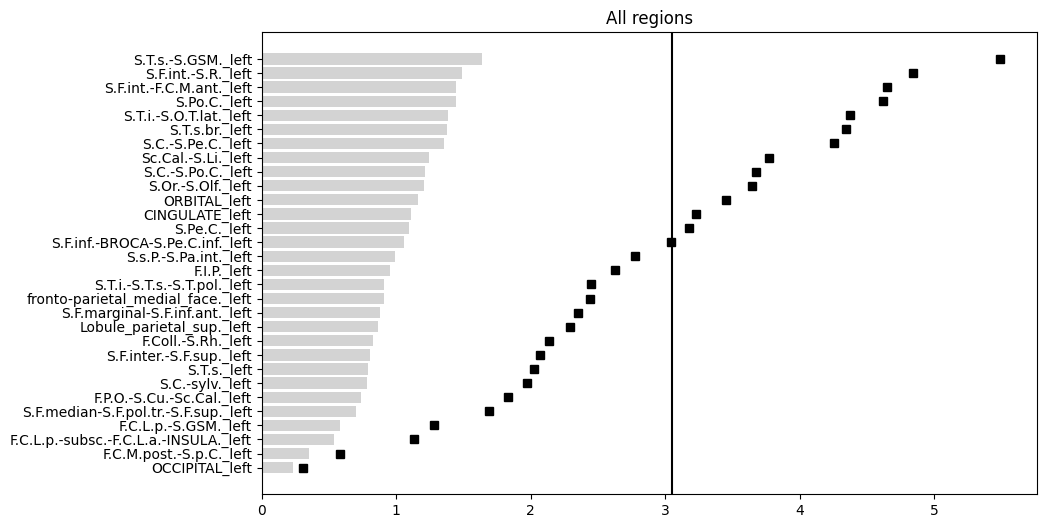

In [56]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

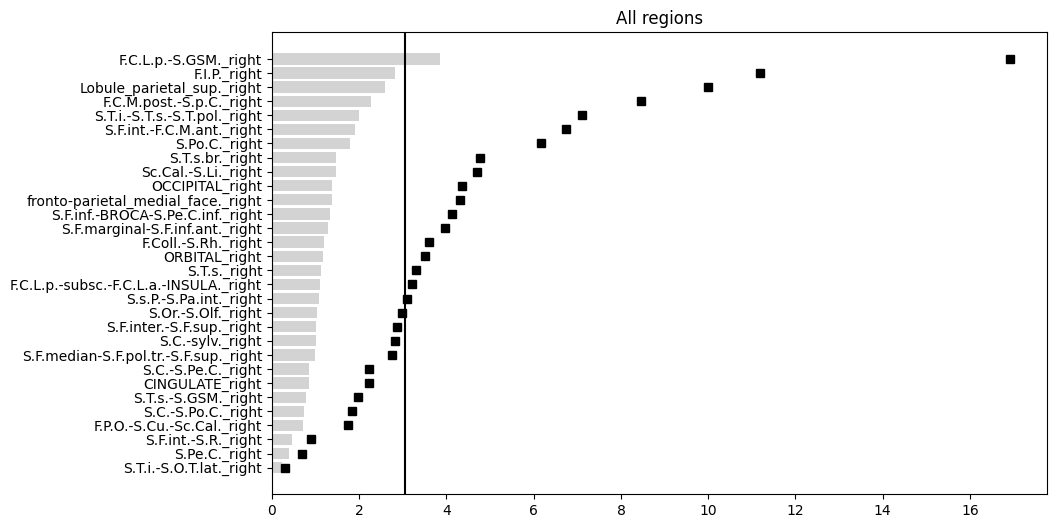

In [57]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

In [58]:
# df.to_csv(output_filename)